# Static Ordinal Regression with MIMIC dataset
----

## Imports

In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

In [2]:
sys.path.append(os.path.abspath(os.path.join('../utils')))
from ordinal_model.OrdinalRegression import OrdinalRegression, plot_model

## Data Preprocessing

In [3]:
X_train = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/x_train.csv')
y_train = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/y_train.csv')
X_valid = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/x_valid.csv')
y_valid = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/y_valid.csv')
X_test = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/x_test.csv')
y_test = pd.read_csv('/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/y_test.csv')

In [4]:
X_data = [X_train, X_valid, X_test]
y_data = [y_train, y_valid, y_test]

In [5]:
X_train.head()

,Unnamed: 0,subject_id,hadm_id,stay_id,hours_from_admission,timestamp,Heart Rate,Respiratory Rate,O2 saturation pulseoxymetry,Non Invasive Blood Pressure systolic,...,AST,Direct Bilirubin,Total Bilirubin,Troponin-T,Venous CO2 Pressure,admission_timestamp_x,Age,is_gender_male,is_gender_unknown,admission_timestamp_y
0,0,12466550,23998182,30000153,0.0,2174-09-29 12:09:00,104.0,16.0,100.0,113.0,...,NaN,NaN,NaN,NaN,NaN,2174-09-29 12:09:00,61,1,0,2174-09-29 12:09:00
1,1,12466550,23998182,30000153,1.0,2174-09-29 13:09:00,NaN,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2174-09-29 12:09:00,61,1,0,2174-09-29 12:09:00
2,2,12466550,23998182,30000153,2.0,2174-09-29 14:09:00,83.0,NaN,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2174-09-29 12:09:00,61,1,0,2174-09-29 12:09:00
3,3,12466550,23998182,30000153,3.0,2174-09-29 15:09:00,83.0,16.0,100.0,NaN,...,NaN,NaN,NaN,0.01,NaN,2174-09-29 12:09:00,61,1,0,2174-09-29 12:09:00
4,4,12466550,23998182,30000153,4.0,2174-09-29 16:09:00,103.0,20.0,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2174-09-29 12:09:00,61,1,0,2174-09-29 12:09:00


In [6]:
X_train.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'stay_id',
       'hours_from_admission', 'timestamp', 'Heart Rate', 'Respiratory Rate',
       'O2 saturation pulseoxymetry', 'Non Invasive Blood Pressure systolic',
       'Non Invasive Blood Pressure diastolic', 'Temperature Fahrenheit',
       'Height (cm)', 'Respiratory Rate (Total)', 'Potassium (serum)',
       'Sodium (serum)', 'Chloride (serum)', 'Hematocrit (serum)',
       'Hemoglobin', 'Creatinine (serum)', 'Glucose (serum)', 'Magnesium',
       'Phosphorous', 'Platelet Count', 'Glucose (whole blood)',
       'Daily Weight', 'Absolute Neutrophil Count', 'Prothrombin time',
       'Fibrinogen', 'PH (Arterial)', 'PH (Venous)', 'HCO3 (serum)',
       'Arterial O2 pressure', 'Arterial CO2 Pressure', 'Lactic Acid',
       'Albumin', 'Calcium non-ionized', 'C Reactive Protein (CRP)', 'ALT',
       'AST', 'Direct Bilirubin', 'Total Bilirubin', 'Troponin-T',
       'Venous CO2 Pressure', 'admission_timestamp_x', 'Age', 'is_gender_male',


In [7]:
y_train.head()

,Unnamed: 0,subject_id,hadm_id,stay_id,in_icu_mortality,length_of_stay_in_hours,admission_timestamp,los_geq_3_days,los_geq_7_days,los_geq_11_days
0,0,12466550,23998182,30000153,0,39.286111,2174-09-29 12:09:00,0,0,0
1,1,13180007,27543152,30000213,0,39.246667,2162-06-21 05:38:00,0,0,0
2,3,12207593,22795209,30000646,0,112.740556,2194-04-29 01:39:22,1,0,0
3,4,12168737,29283664,30001336,0,66.682222,2186-03-20 00:44:48,0,0,0
4,6,17461994,29537385,30001471,0,81.092500,2189-05-02 06:57:00,1,0,0


In [8]:
y_train.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'stay_id', 'in_icu_mortality',
       'length_of_stay_in_hours', 'admission_timestamp', 'los_geq_3_days',
       'los_geq_7_days', 'los_geq_11_days'],
      dtype='object')

In [9]:
X_train_cols = X_train[['Age','is_gender_male', 'Daily Weight', 'Height (cm)']]

In [10]:
X_train_cols['bmi'] = X_train_cols['Daily Weight'] / (X_train_cols['Height (cm)'] ** 2)

/tmp/ipykernel_2609/594775279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cols['bmi'] = X_train_cols['Daily Weight'] / (X_train_cols['Height (cm)'] ** 2)


In [11]:
X_train_cols['bmi'][~X_train_cols['bmi'].isna()]

9542      0.003429
9550      0.003433
11933     0.003583
14525     0.002351
14614     0.002994
            ...   
788920    0.003124
789177    0.002360
792957    0.002345
792964    0.002465
797115    0.002995
Name: bmi, Length: 316, dtype: float64

### Preprocess Functions
* `preprocess_X_df()`
    * Isolates the features of interest
    * Obtains the first observed values of certain features (i.e `Heart Rate`, `Non Invasive Blood Pressure diastolic`)
    * Optional: Normalize the data with the `normalize` flag set to `True`
* `preprocess_y_df()`
    * Isolates the labels for length of stays
    * Engineers ordinal feature labels

In [12]:
def preprocess_X_df(df, normalize=False):
    # Assume stay_id is primary key
    columns = ['stay_id', 'hours_from_admission', 'Heart Rate', 'Non Invasive Blood Pressure diastolic','Age', 'is_gender_male']
    # Sort the rows by admission time so that first value is earliest
    df = df[columns].copy().sort_values(['stay_id', 'hours_from_admission',])
    # Groupby
    preprocessed_df = df.groupby('stay_id').first()
    preprocessed_df = preprocessed_df.reset_index().drop(columns='hours_from_admission')
    # Fill na with mean values
    mean_values = preprocessed_df.mean()
    preprocessed_df = preprocessed_df.fillna(mean_values)
    # Normalize
    if normalize:
        normalize_cols = ['Heart Rate', 'Non Invasive Blood Pressure diastolic', 'Age']
        preprocessed_df[normalize_cols] = (preprocessed_df[normalize_cols] - preprocessed_df[normalize_cols].mean()) / preprocessed_df[normalize_cols].std()
    return preprocessed_df
    

In [13]:
def preprocess_y_df(df):
    # Assume stay_id is primary key, sort in same order as X dataset
    columns = ['stay_id', 'los_geq_3_days', 'los_geq_7_days', 'los_geq_11_days']
    df = df[columns].copy().sort_values(['stay_id'])
    # Determine ordinal label
    df['ordinal_label'] = df.iloc[:,-3:].sum(axis=1)
    return df

# Binary Classification

## >3 days

In [14]:
# sklearn classifier
clf = LogisticRegression()
clf.fit(preprocess_X_df(X_train, normalize=True).iloc[:,1:], preprocess_y_df(y_train)['los_geq_3_days'])

LogisticRegression()

In [15]:
# Compute probability scores
y_score_train = clf.predict_proba(preprocess_X_df(X_train).iloc[:,1:])
y_score_valid = clf.predict_proba(preprocess_X_df(X_valid).iloc[:,1:])
y_score_test = clf.predict_proba(preprocess_X_df(X_test).iloc[:,1:])
y_scores = [y_score_train, y_score_valid, y_score_test]

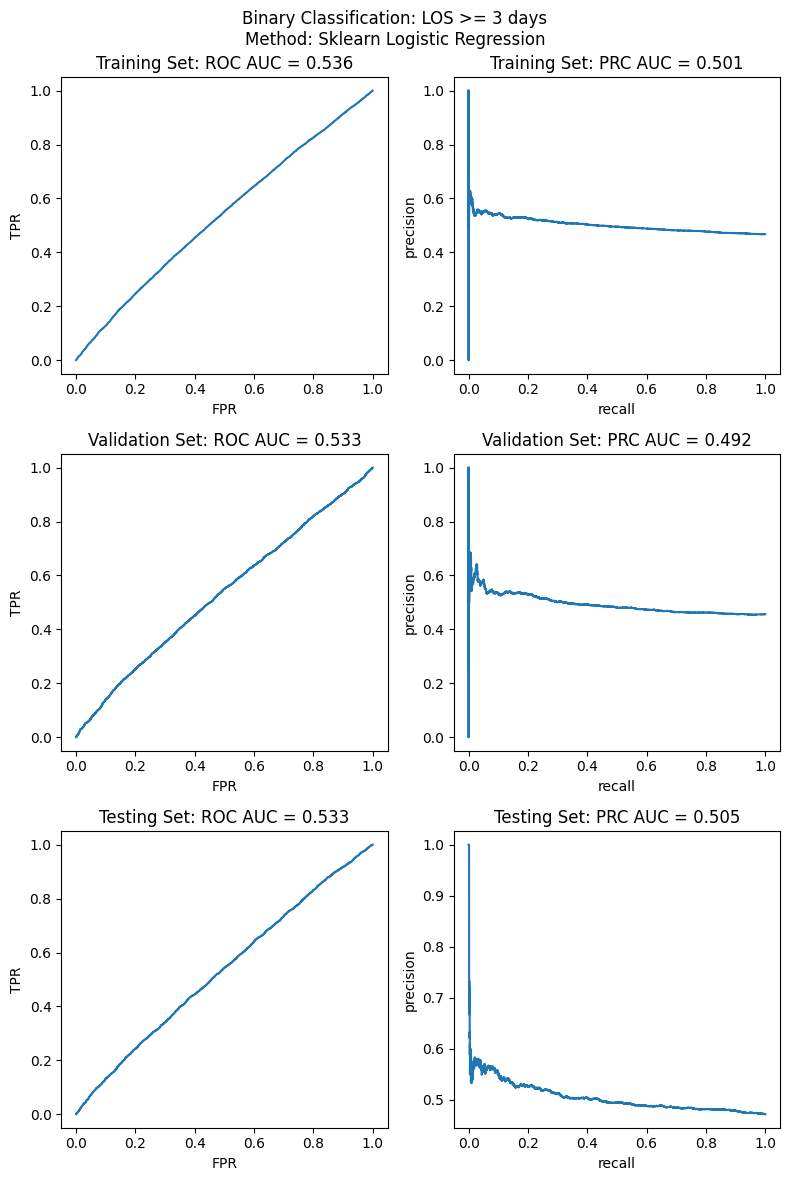

In [16]:
# Plot ROC & PRC
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i][:,1])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i][:,1])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Binary Classification: LOS >= 3 days\nMethod: Sklearn Logistic Regression')
plt.tight_layout()
plt.show()

## >7 days

In [17]:
# sklearn classifier
clf = LogisticRegression()
clf.fit(preprocess_X_df(X_train).iloc[:,1:], preprocess_y_df(y_train)['los_geq_7_days'])

LogisticRegression()

In [18]:
# Compute probability scores
y_score_train = clf.predict_proba(preprocess_X_df(X_train).iloc[:,1:])
y_score_valid = clf.predict_proba(preprocess_X_df(X_valid).iloc[:,1:])
y_score_test = clf.predict_proba(preprocess_X_df(X_test).iloc[:,1:])
y_scores = [y_score_train, y_score_valid, y_score_test]

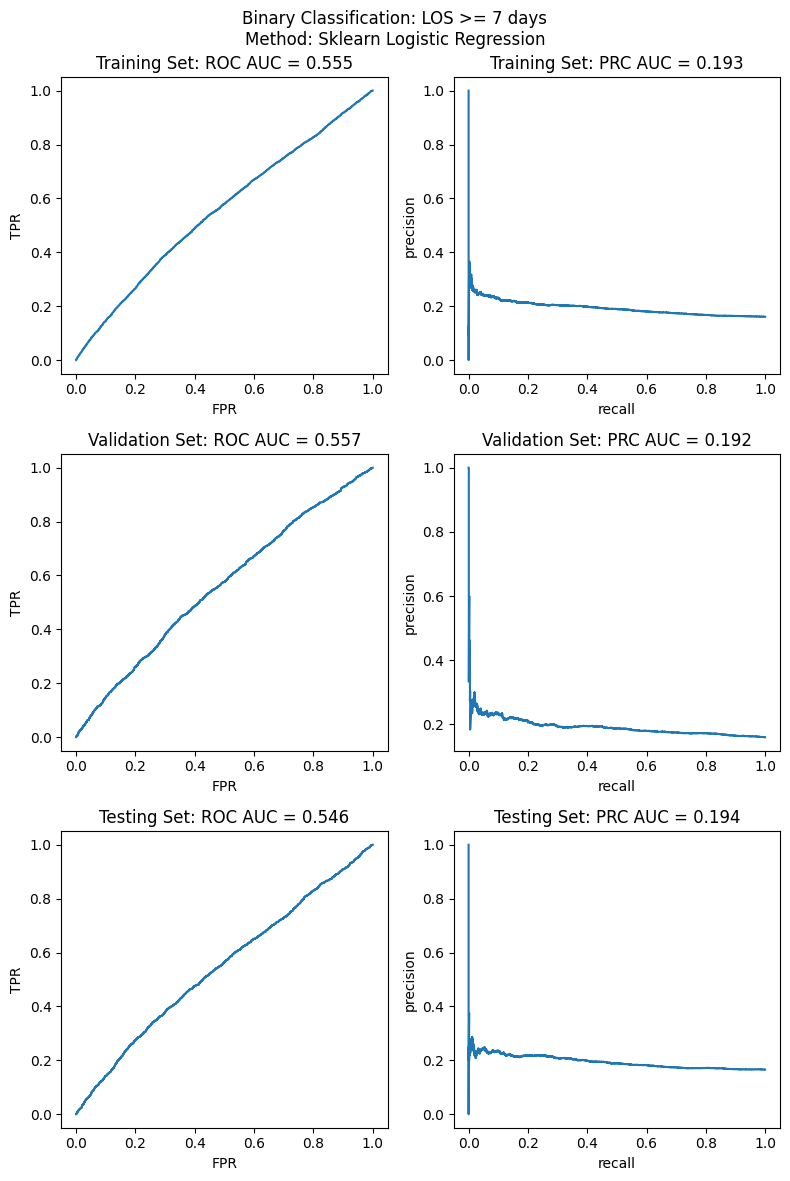

In [19]:
# Plot ROC & PRC
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i][:,1])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i][:,1])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Binary Classification: LOS >= 7 days\nMethod: Sklearn Logistic Regression')
plt.tight_layout()
plt.show()

## >11 days

In [20]:
# Sklearn classifier
clf = LogisticRegression()
clf.fit(preprocess_X_df(X_train).iloc[:,1:], preprocess_y_df(y_train)['los_geq_11_days'])

LogisticRegression()

In [21]:
# Compute probability scores
y_score_train = clf.predict_proba(preprocess_X_df(X_train).iloc[:,1:])
y_score_valid = clf.predict_proba(preprocess_X_df(X_valid).iloc[:,1:])
y_score_test = clf.predict_proba(preprocess_X_df(X_test).iloc[:,1:])
y_scores = [y_score_train, y_score_valid, y_score_test]

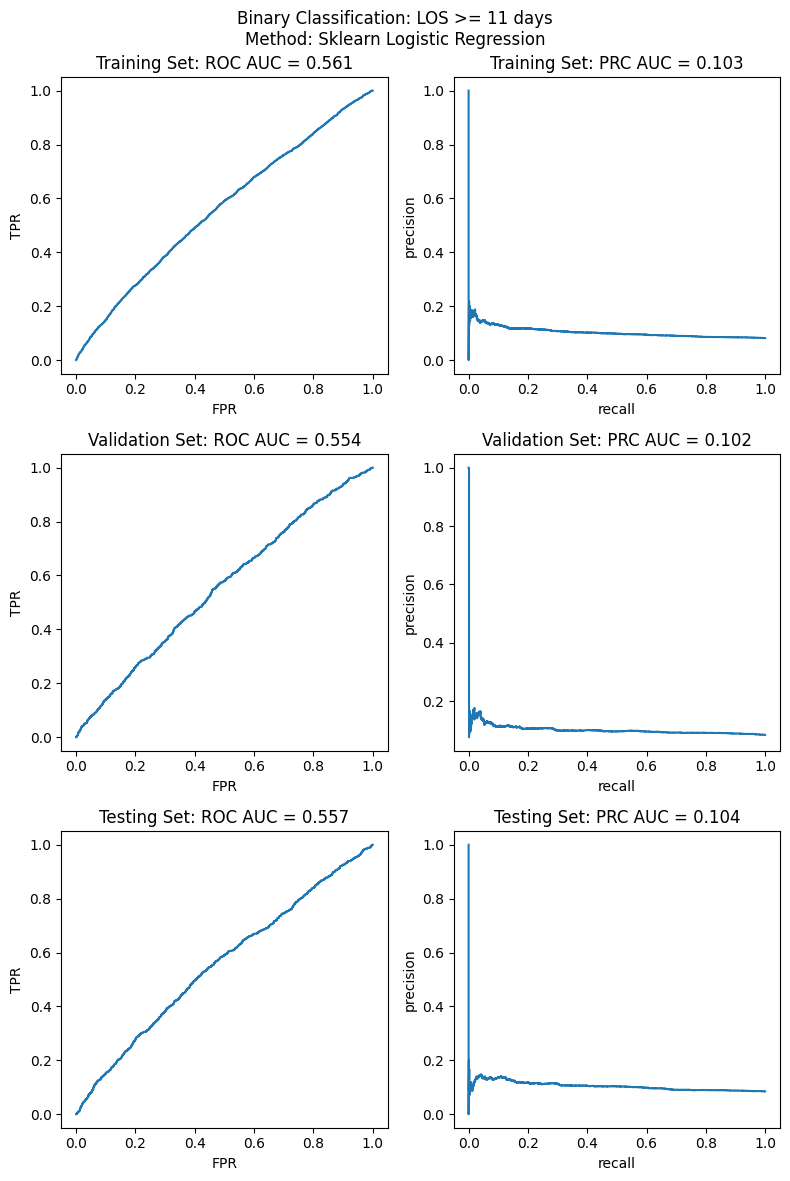

In [22]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i][:,1])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i][:,1])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Binary Classification: LOS >= 11 days\nMethod: Sklearn Logistic Regression')
plt.tight_layout()
plt.show()

# Ordinal Classification

### Training and Model Summary

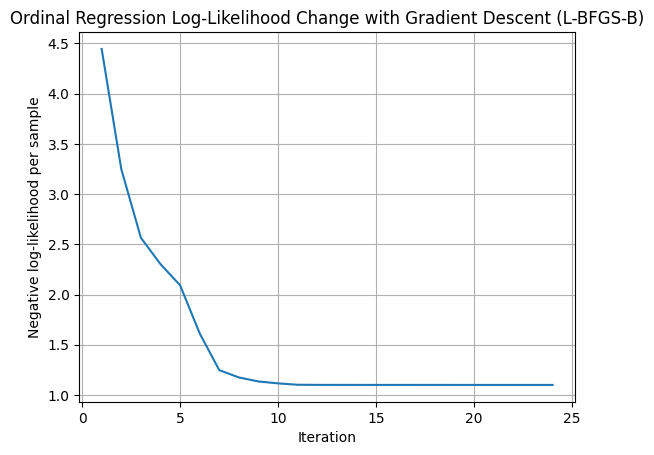

In [23]:
# Autograd Made Ordinal classifier
oc = OrdinalRegression(save_loss=True)
oc.fit(preprocess_X_df(X_train, normalize=True).iloc[:,1:].to_numpy(), preprocess_y_df(y_train)['ordinal_label'].to_numpy())

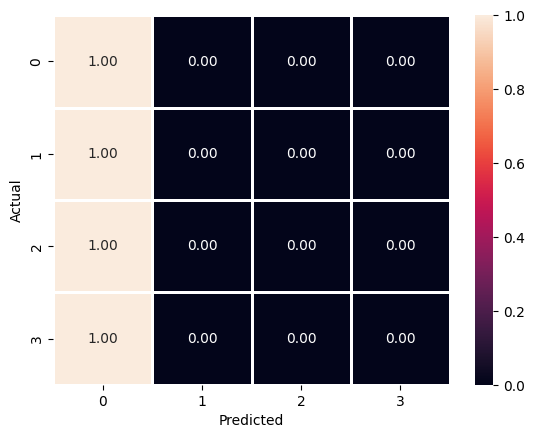

In [24]:
# Confusion Matrix
y = preprocess_y_df(y_train)['ordinal_label'].to_numpy()
y_predict = oc.predict(preprocess_X_df(X_train, normalize=True).iloc[:,1:].to_numpy())

cf_matrix = confusion_matrix(y, y_predict, normalize='true',labels=list(range(y.max()+1)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
plt.show()

In [25]:
# Compute ordinal probabilities for each label
y_probas_train = oc.predict_proba(preprocess_X_df(X_train, normalize=True).iloc[:,1:].to_numpy())
y_probas_valid = oc.predict_proba(preprocess_X_df(X_valid, normalize=True).iloc[:,1:].to_numpy())
y_probas_test = oc.predict_proba(preprocess_X_df(X_test, normalize=True).iloc[:,1:].to_numpy())


## >3 days

In [26]:
# Compute binary probability scores from ordinal probabilities 
y_probas_train_geq3 = y_probas_train[:,1:].sum(axis=1)
y_probas_valid_geq3 = y_probas_valid[:,1:].sum(axis=1)
y_probas_test_geq3 = y_probas_test[:,1:].sum(axis=1)
y_scores = [y_probas_train_geq3, y_probas_valid_geq3, y_probas_test_geq3]

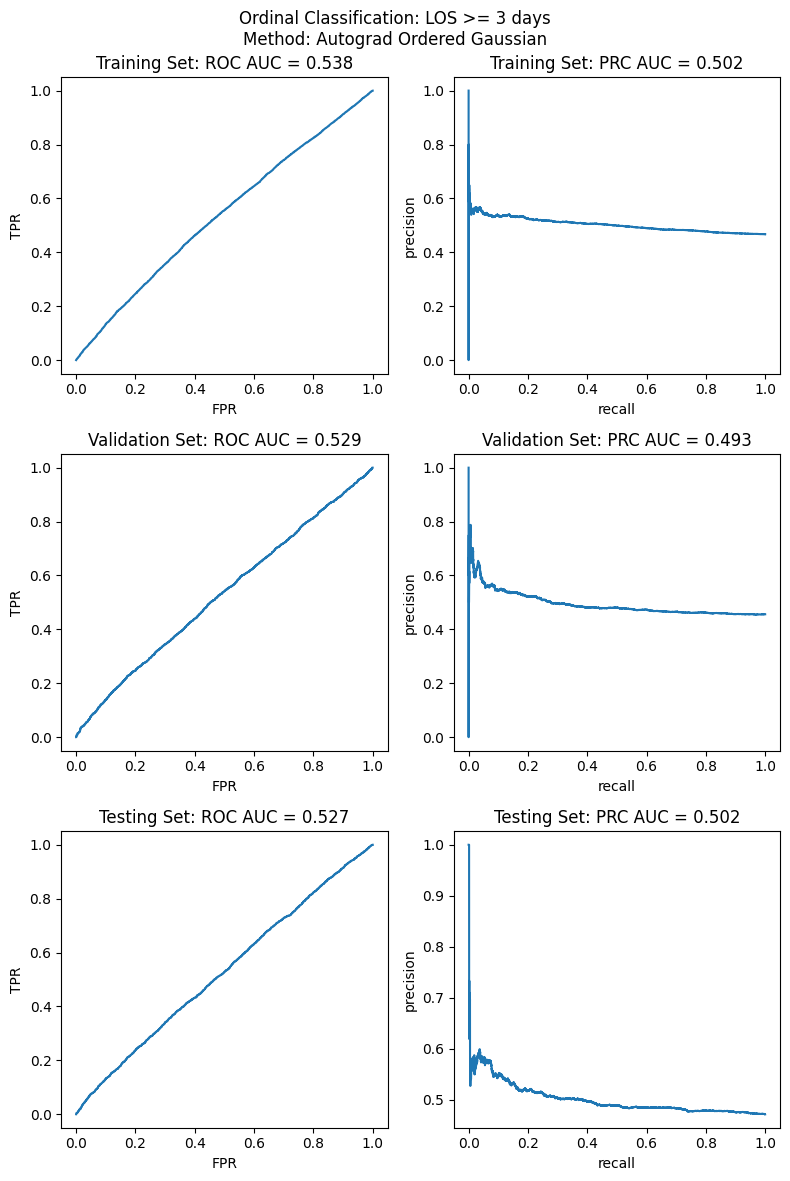

In [27]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_3_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Ordinal Classification: LOS >= 3 days\nMethod: Autograd Ordered Gaussian')
plt.tight_layout()
plt.show()

## >7 days

In [28]:
# Compute binary probability scores from ordinal probabilities 
y_probas_train_geq7 = y_probas_train[:,2:].sum(axis=1)
y_probas_valid_geq7 = y_probas_valid[:,2:].sum(axis=1)
y_probas_test_geq7 = y_probas_test[:,2:].sum(axis=1)

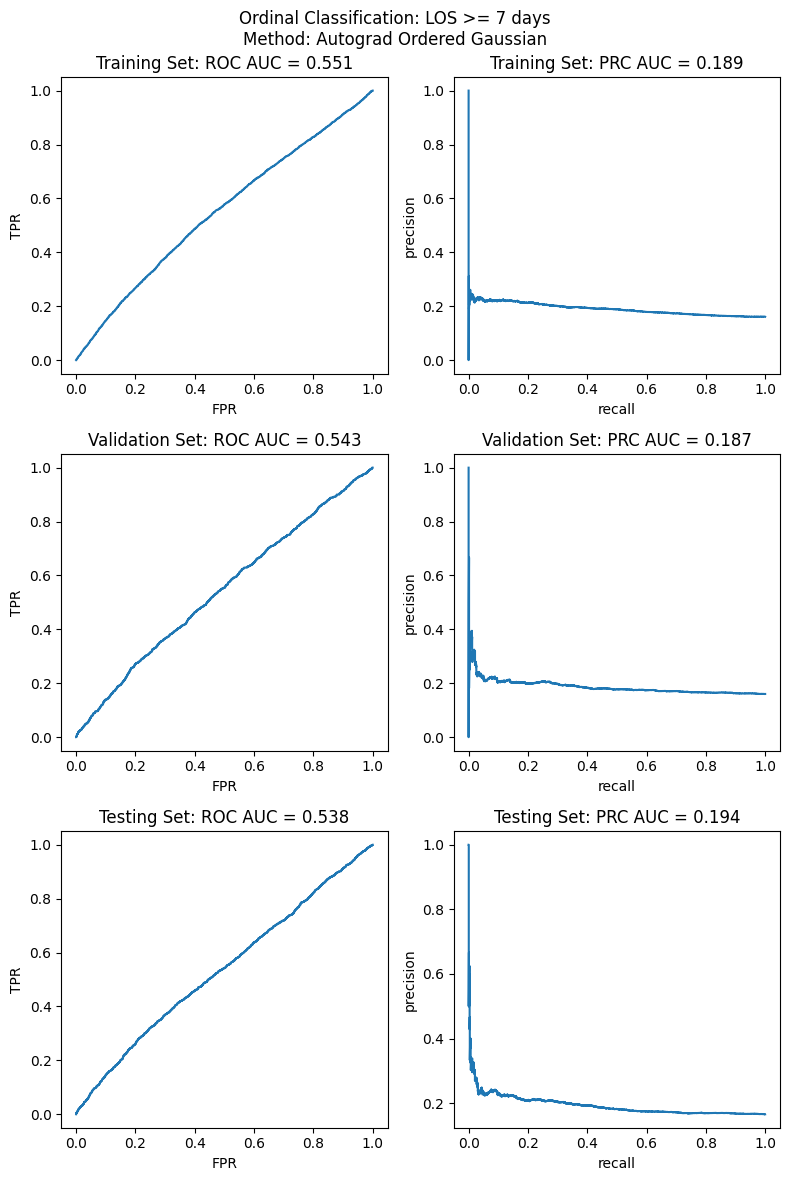

In [29]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_7_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Ordinal Classification: LOS >= 7 days\nMethod: Autograd Ordered Gaussian')
plt.tight_layout()
plt.show()

## >11 days

In [30]:
# Compute binary probability scores from ordinal probabilities 
y_probas_train_geq11 = y_probas_train[:,3:].sum(axis=1)
y_probas_valid_geq11 = y_probas_valid[:,3:].sum(axis=1)
y_probas_test_geq11 = y_probas_test[:,3:].sum(axis=1)

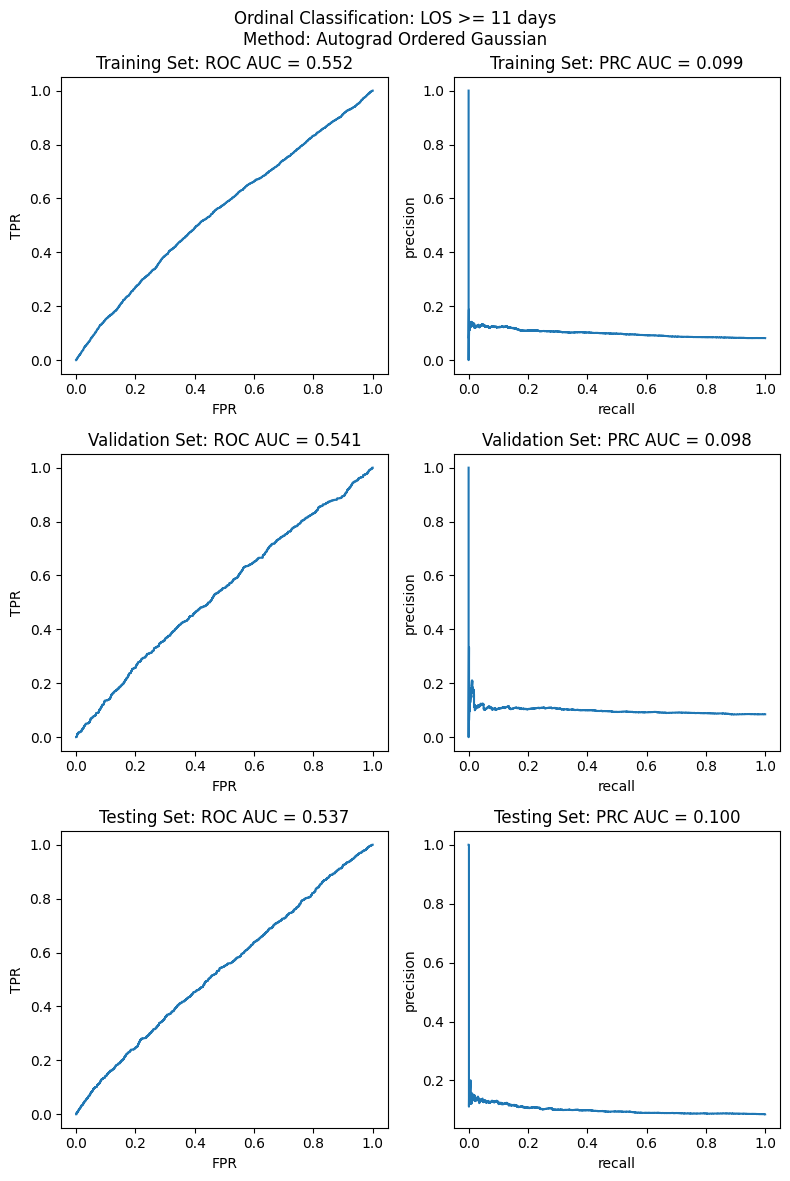

In [31]:
# Plotting
titles = ['Training', 'Validation', 'Testing']
fig, ax = plt.subplots(3,2, figsize=(8,12))
for i in range(3):
    fpr, tpr, thresholds = roc_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i])
    precision, recall, thresholds = precision_recall_curve(preprocess_y_df(y_data[i])['los_geq_11_days'], y_scores[i])
    # Plot ROC
    ax[i,0].plot(fpr, tpr)
    ax[i,0].set_xlabel('FPR')
    ax[i,0].set_ylabel('TPR')
    ax[i,0].set_title(f'{titles[i]} Set: ROC AUC = {auc(fpr, tpr):0.3f}')
    # Plot PRC
    ax[i,1].plot(recall, precision)
    ax[i,1].set_xlabel('recall')
    ax[i,1].set_ylabel('precision')
    ax[i,1].set_title(f'{titles[i]} Set: PRC AUC = {auc(recall, precision):0.3f}')
fig.suptitle('Ordinal Classification: LOS >= 11 days\nMethod: Autograd Ordered Gaussian')
plt.tight_layout()
plt.show()